Dashboard:
https://coronavirus.data.gov.uk/

Covid API General Use:
https://publichealthengland.github.io/coronavirus-dashboard-api-python-sdk/pages/examples/general_use.html

Covid API Developer's Guide:
https://coronavirus.data.gov.uk/details/developers-guide

Covid API Developer's Guide, Metrics:
https://coronavirus.data.gov.uk/details/developers-guide#structure-metrics

In [10]:
from uk_covid19 import Cov19API
import json
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as wdg
import numpy as np


%matplotlib inline
plt.rcParams['figure.dpi'] = 100


Filter provides the functionality to filter the data that you receive in response to a request.

Filters must be formatted as [metricName]=[value], where[metricName] is the name of an authorised filter metric and [value] is a value of the given metric based on which the data are to be filtered.

For instance, to retrieve data for Cambridge, the filter is defined as filters=areaName=Cambridge


The structure parameter defines:

The metrics that you wish to receive in the response
The structure in which you wish to receive the response
You may additionally use the structure parameter to rename the parameters. This feature is primarily designed to provide backward compatibility and minimise disruption to services that rely on legacy downloads.

The value of the structure parameter is a JSON-formatted string, where:

The keys define the name of a parameter in the response
The values define the metric that you wish to receive in the response
The structure defines the overall structure of the JSON / XML response. For CSV outputs, a flat structure or a JSON array must be defined.

"Structure is a dictionary that specifies which data fields you want to request. In fact, looking at the API documentation for structures shows that they do more: they also specify the "format" in which you want to receive the response."

In [11]:
def parse_date(datestring):
    """ Convert a date string into a pandas datetime object """
    return pd.to_datetime(datestring, format="%Y-%m-%d")

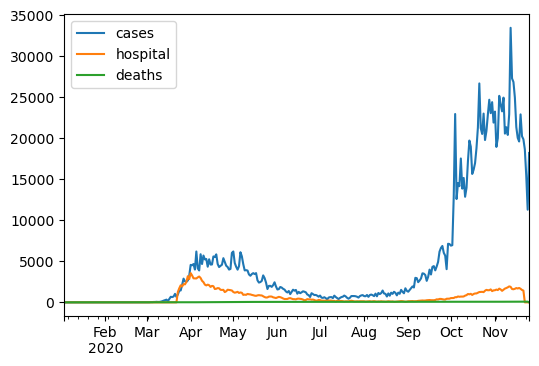

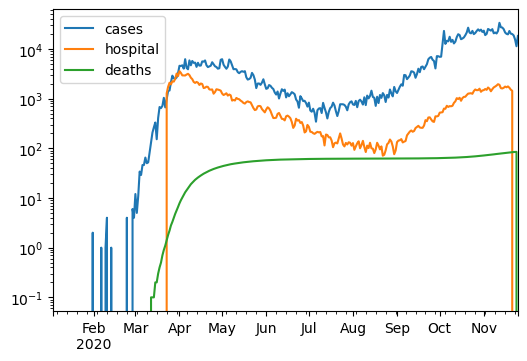

In [12]:
def getTimeSeries():
    filters = [
        'areaType=overview' 
    ]

    structure = {
        "date": "date",
        "cases": "newCasesByPublishDate",
        "hospital": "newAdmissions",
        "deaths": "cumDeaths28DaysByDeathDateRate"    
    }

    api = Cov19API(filters=filters, structure=structure)
    timeSeries=api.get_json()

    
    with open("timeSeries.json", "wt") as OUTF:
        json.dump(timeSeries, OUTF)
    
    with open("timeSeries.json", "rt") as INFILE:
        timeSeriesData=json.load(INFILE)
    
    timeSeriesDataList = timeSeriesData['data']
    
    timeSeriesDates=[dictionary['date'] for dictionary in timeSeriesDataList]
    timeSeriesDates.sort()
    timeSeriesDates

    timeSeriesStartDate = parse_date(timeSeriesDates[0])
    timeSeriesEndDate = parse_date(timeSeriesDates[-1])

    index = pd.date_range(timeSeriesStartDate, timeSeriesEndDate, freq ='D')
    timeSeriesDataFrame = pd.DataFrame(index=index, columns = ['cases', 'hospital', 'deaths'])
    timeSeriesDataFrame

    for entry in timeSeriesDataList:
        date=parse_date(entry['date'])
        for column in ['cases', 'hospital', 'deaths']:
            if pd.isna(timeSeriesDataFrame.loc[date, column]): 
                value= float(entry[column]) if entry[column]!=None else 0.0
                timeSeriesDataFrame.loc[date, column]=value
    timeSeriesDataFrame.fillna(0.0, inplace=True)      
    timeSeriesDataFrame

    timeSeriesDataFrame.plot()
    timeSeriesDataFrame.plot(logy=True)
    

    timeSeriesDataFrame.to_pickle("timeSeriesDataFrame.pkl")

getTimeSeries()

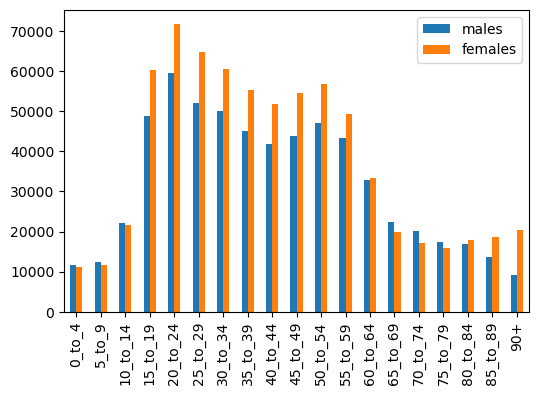

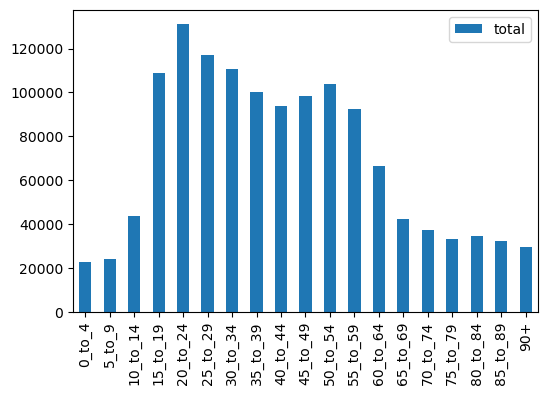

In [13]:
def getAgeDistribution():

    filters = [
    'areaType=nation',
    'areaName=England'
    ]


    structure = {
    "males": "maleCases",
    "females": "femaleCases"
    }

    api = Cov19API(filters=filters, structure=structure)
    ageDistribution=api.get_json()

    with open("ageDistribution.json", "wt") as OUTF:
        json.dump(ageDistribution, OUTF)

    with open("ageDistribution.json", "rt") as INFILE:
        ageDistributionData=json.load(INFILE)

    ageDistributionDataList = ageDistributionData['data']
    ageDistributionData

    dataDic=ageDistributionData['data'][0]

    dataDic

    males=dataDic['males']
    females=dataDic['females']
    males

    ageranges=[x['age'] for x in males] 

    def min_age(agerange):

        agerange=agerange.replace('+','') 
        start=agerange.split('_')[0]
        return int(start)

    ageranges.sort(key=min_age)

    ageDataFrame=pd.DataFrame(index=ageranges, columns=['males','females', 'total'])

    for entry in males: 
        ageband=entry['age'] 
        ageDataFrame.loc[ageband, 'males']=entry['value']

    for entry in females:
        ageband=entry['age']
        ageDataFrame.loc[ageband, 'females']=entry['value']

    ageDataFrame['total']=ageDataFrame['males']+ageDataFrame['females']
    ageDataFrame

    ageDataFrame.plot(kind='bar', y=['males','females'])
    ageDataFrame.plot(kind='bar', y='total')
    
    ageDataFrame.to_pickle("ageDataFrame.pkl")

getAgeDistribution()

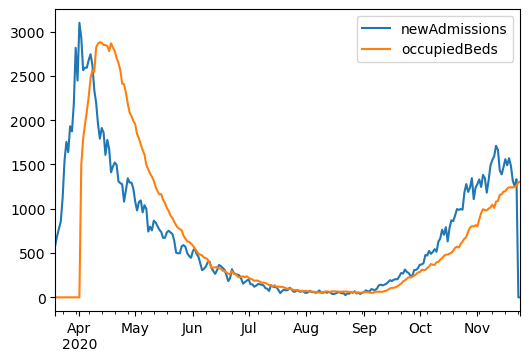

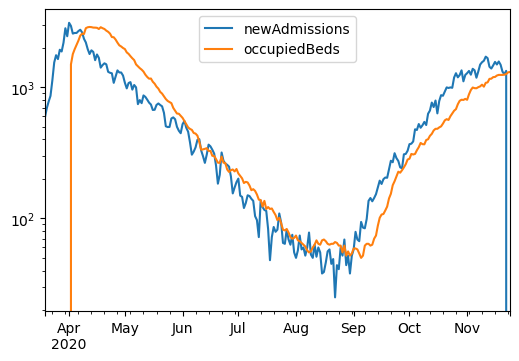

In [14]:
def getAdmissionsBeds():

    filters = [
        'areaType=nation',
        'areaName=England'
    ]


    structure = {
        "date":"date",
        "newAdmissions":"newAdmissions",
        "occupiedBeds":"covidOccupiedMVBeds"
    }

    api = Cov19API(filters=filters, structure=structure)
    admissionsBeds=api.get_json()

    with open("admissionsBeds.json", "wt") as OUTF:
        json.dump(admissionsBeds, OUTF)

    with open("admissionsBeds.json", "rt") as INFILE:
        admissionsBedsData=json.load(INFILE) 

        admissionsBedsDataList = admissionsBedsData['data']

        admissionsBedsDates=[dictionary['date'] for dictionary in admissionsBedsDataList]
        admissionsBedsDates.sort()
        admissionsBedsDates

        admissionsBedsStartDate = parse_date(admissionsBedsDates[0])
        admissionsBedsEndDate = parse_date(admissionsBedsDates[-1])

        index = pd.date_range(admissionsBedsStartDate, admissionsBedsEndDate, freq ='D')
        admissionsBedsDataFrame = pd.DataFrame(index=index, columns = ['newAdmissions', 'occupiedBeds'])
        admissionsBedsDataFrame

        for entry in admissionsBedsDataList:
            date=parse_date(entry['date'])
            for column in ['newAdmissions', 'occupiedBeds']:
                if pd.isna(admissionsBedsDataFrame.loc[date, column]): 
                    value= float(entry[column]) if entry[column]!=None else 0.0
                    admissionsBedsDataFrame.loc[date, column]=value

        admissionsBedsDataFrame.fillna(0.0, inplace=True)      
        admissionsBedsDataFrame

        admissionsBedsDataFrame.plot()
        admissionsBedsDataFrame.plot(logy=True)

        admissionsBedsDataFrame.to_pickle("admissionsBedsDataFrame.pkl")
        
getAdmissionsBeds()

Button(description='Refresh data', icon='download', style=ButtonStyle(), tooltip='Click to download current Pu…

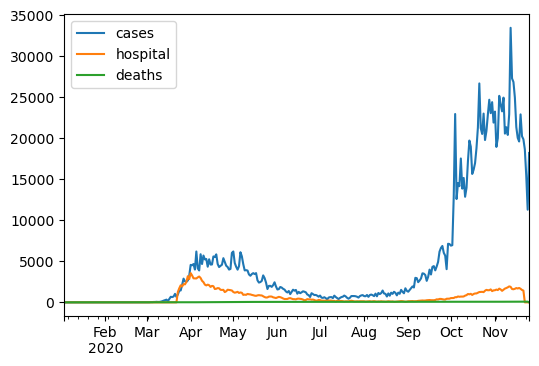

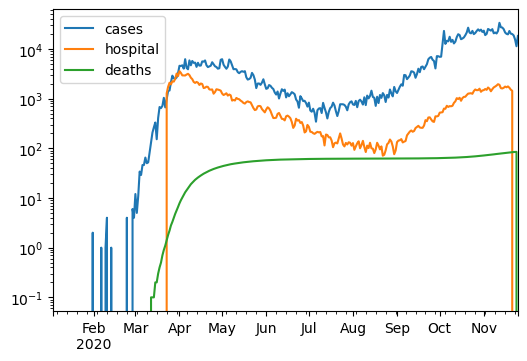

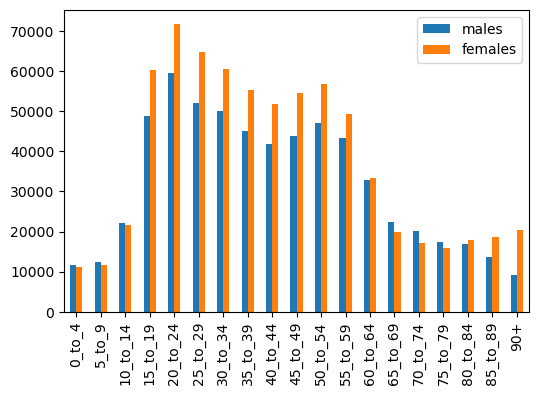

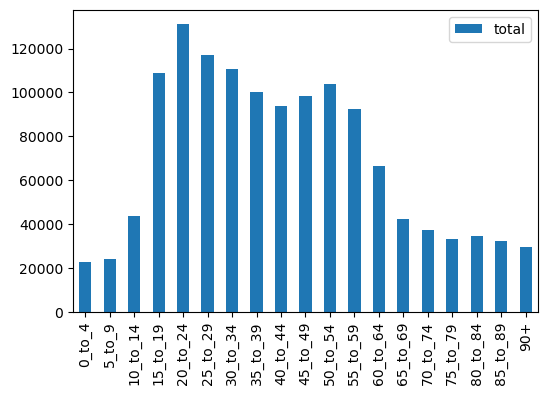

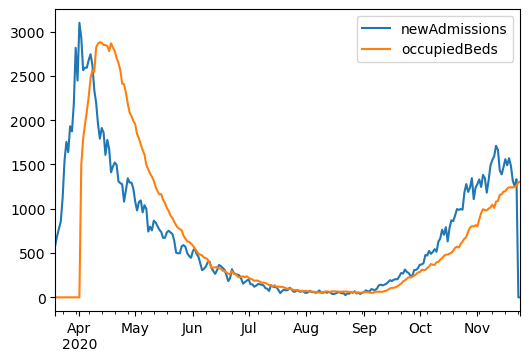

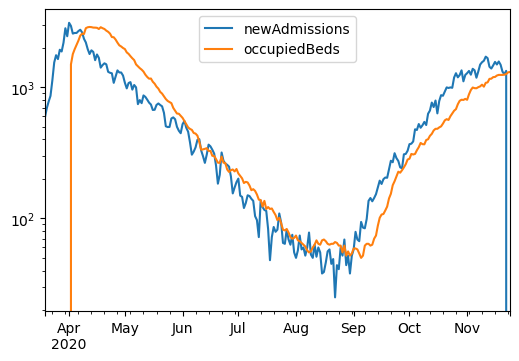

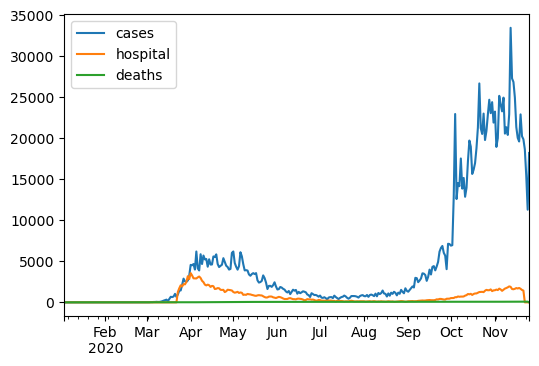

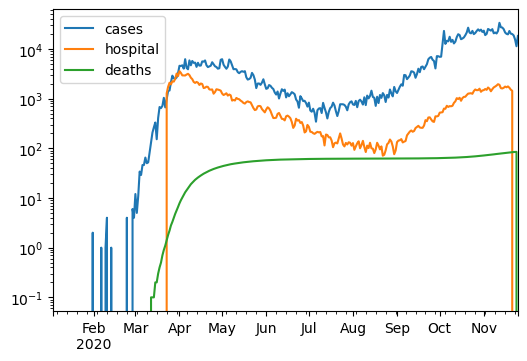

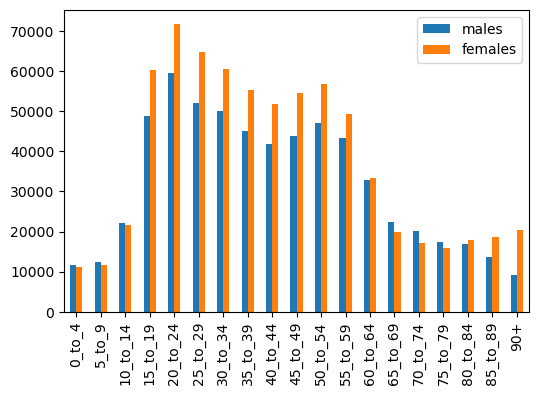

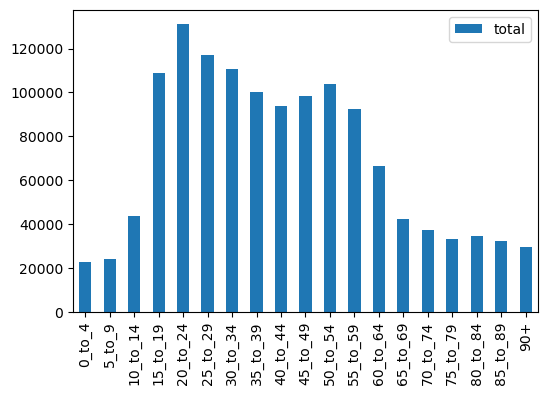

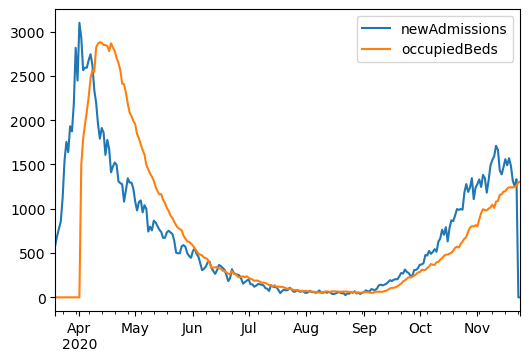

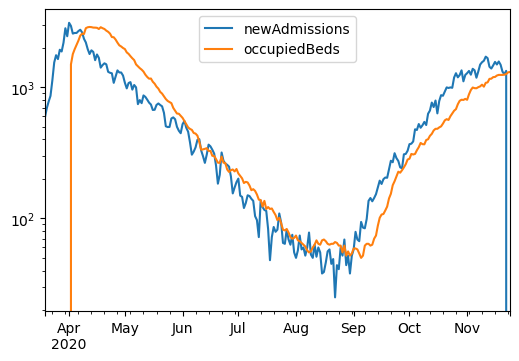

In [15]:
def access_api(button):
    getTimeSeries()
    getAgeDistribution()
    getAdmissionsBeds()

    
apibutton=wdg.Button(
    description='Refresh data',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to download current Public Health England data',
    icon='download' # (FontAwesome names without the `fa-` prefix)
)

apibutton.on_click(access_api)
display(apibutton)

In [16]:
ageDataFrame=pd.read_pickle("ageDataFrame.pkl")

agecols = wdg.SelectMultiple(
    options=['males', 'females', 'total'], 
    value=['males', 'females'],
    rows=3, 
    description='Sex',
    disabled=False
)

def age_graph(graphcolumns):
    ncols=len(graphcolumns)
    if ncols>0:
        ageDataFrame.plot(kind='bar', y=list(graphcolumns)) 
    else:
        print("Click to select data for graph")
        print("(CTRL-Click to select more than one category)")
    
output=wdg.interactive_output(age_graph, {'graphcolumns': agecols})

display(agecols, output)

SelectMultiple(description='Sex', index=(0, 1), options=('males', 'females', 'total'), rows=3, value=('males',…

Output()

In [17]:
timeSeriesDataFrame=pd.read_pickle("timeSeriesDataFrame.pkl")


series=wdg.SelectMultiple(
    options=['cases', 'hospital', 'deaths'],
    value=['cases', 'hospital', 'deaths'],
    rows=3,
    description='Stats:',
    disabled=False
)

scale=wdg.RadioButtons(
    options=['linear', 'log'],
    description='Scale:',
    disabled=False
)

controls=wdg.HBox([series, scale])

def timeseries_graph(gcols, gscale):
    if gscale=='linear':
        logscale=False
    else:
        logscale=True
    ncols=len(gcols)
    if ncols>0:
        timeSeriesDataFrame[list(gcols)].plot(logy=logscale)
    else:
        print("Click to select data for graph")
        print("(CTRL-Click to select more than one category)")

graph=wdg.interactive_output(timeseries_graph, {'gcols': series, 'gscale': scale})

display(controls, graph)

# stack series and scale on top of each other
ctrls=wdg.HBox([series, scale])

# put the graph and the controls side by side
form=wdg.HBox([graph, ctrls])

# Now form contains the entire interface
# display(form)



Output()

In [18]:
admissionsBedsDataFrame=pd.read_pickle("admissionsBedsDataFrame.pkl")

admissions=wdg.SelectMultiple(
    options=['newAdmissions','occupiedBeds'],
    value=['newAdmissions','occupiedBeds'],
    rows=2,
    description='Stats:',
    disabled=False
)

admissionsControls=wdg.HBox([admissions, scale])

def admissions_beds_graph(gcols, gscale):
    if gscale=='linear':
        logscale=False
    else:
        logscale=True
    ncols=len(gcols)
    if ncols>0:
        admissionsBedsDataFrame[list(gcols)].plot(logy=logscale)
    else:
        print("Click to select data for graph")
        print("(CTRL-Click to select more than one category)")

admissionsGraph=wdg.interactive_output(admissions_beds_graph, {'gcols': admissions, 'gscale': scale})

display(admissionsControls, admissionsGraph)

admissionsCtrls=wdg.VBox([admissions, scale])

form=wdg.HBox([admissionsGraph, admissionsCtrls])



Output()